# Sentiment analysis

In this notebook, we will train a neural network on a labeled dataset to predict the sentiment of financial news headlines.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## A small custom test dataset

The objective is to correctly label these test cases as positive, neutral, or negative (the `real` value). We purposefully choose both simple adjectives and financial news headlines.

In [2]:
custom_sentences = [
    {
        "real": 1,
        "sentences": [
            "good",
            "great",
            "amazing",
            "Ad tech company PubMatic stock pops 10% in first earnings report after December IPO",
            "USPS unveils next-generation mail truck with electric drivetrain option",
        ]
    },
    {
        "real": 0,
        "sentences": [
            "everyone knows",
            "the subject is",
            "on the other hand",
            "Stock futures little changed after Tuesday's intraday comeback",
            "Here's what investors should know about rocket builder Astra as it prepares to go public",
        ]
    },
    {
        "real": -1,
        "sentences": [
            "bad",
            "awful",
            "terrible",
            "Tesla stock falls more than 10% in two days as bitcoin also tumbles: CNBC After Hours",
            "Microsoft-owned LinkedIn goes down for some users",
        ]
    }
]

## Financial News dataset

We'll start with a dataset that labels the sentiment of financial news headlines, from [Kaggle](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news). We immediately map sentiment strings to integers.

In [3]:
fns = pd.read_csv("financial_news_sentiment.csv", names=["sentiment", "headline"])
fns["target"] = fns["sentiment"].map(
    {
        "positive": 1,
        "neutral": 0,
        "negative": -1,
    }
)
fns.head()

,sentiment,headline,target
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,-1
3,positive,With the new production plant the company woul...,1
4,positive,According to the company 's updated strategy f...,1


We split our dataset for training and testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(fns.headline, fns.target, test_size=0.20, random_state=1)

## Grid Search

Our model will first use a TF-IDF Vectorizer to transform the words into features, and then a regression Multi-Layer Perceptron (MLP) to predict the sentiment.

We will perform a quick grid search to optimize on some parameters. We leave those parameters to their default so that the grid search can work properly.

In [5]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95)),
    ('clf', MLPRegressor(random_state=1)),
])

Perform a grid search to optimize the size of the hidden layers.

In [6]:
parameters = {
    "clf__hidden_layer_sizes": [10, 50, 100, 150],
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={
        "clf__hidden_layer_sizes": [10, 50, 100, 200],
    },
    n_jobs=-1,
    verbose=4
)

The search is computationally intensive, so only run on $1/4^{th}$ of the training set.

In [7]:
%%time
mini_size = int(X_train.size / 4)
X_train_small = X_train[:mini_size]
y_train_small = y_train[:mini_size]
_ = grid_search.fit(X_train_small, y_train_small)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 8.94 s, sys: 6.73 s, total: 15.7 s
Wall time: 23.1 s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.95, min_df=3,
                                                        ngram_range=(1, 2))),
                                       ('clf', MLPRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'clf__hidden_layer_sizes': [10, 50, 100, 150]},
             verbose=4)

In [8]:
grid_search.cv_results_["mean_test_score"]

array([-0.06327483,  0.01133472,  0.030172  ,  0.05824465])

Unsurprisingly, the score increases with the hidden layer size.

## Fit and score

We'll use the largest hidden layer size that our computational power can tolerate. We wrap these operations in a function so we can reuse them, overriding the model every time but saving the prediction results.

In [9]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95)),
    ('clf', MLPRegressor(random_state=1, hidden_layer_sizes=100)),
])

In [10]:
def get_predictions(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset.headline, dataset.target, test_size=0.20, random_state=1)

    pipeline.fit(X_train, y_train)
    print(f"train score: {pipeline.score(X_train, y_train):.3f}")
    print(f"test score: {pipeline.score(X_test, y_test):.3f}")

    predictions = pd.DataFrame(columns=["real", "prediction"])
    for sentiment_group in custom_sentences:
        for sentence in sentiment_group["sentences"]:
            predictions.loc[predictions.size] = [sentiment_group["real"], pipeline.predict([sentence])[0]]

    return predictions

train score: 0.995
test score: 0.220


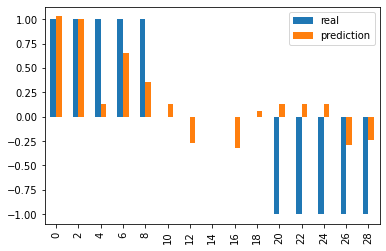

In [11]:
fns_predictions = get_predictions(fns)
ax = fns_predictions.plot(kind="bar")

The positive tests are rated highly, but the negative tests are rated either above 0 or barely negative. Our model performs well on financial headlines (the last two tests in each sentiment), but not as well on simple adjectives.

Perhaps we need to use a simpler dataset with no bias to finance.

## Movie Reviews dataset

This time we'll train the same model but on the [IMDb Reviews Dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [12]:
imdb = pd.read_csv("imdb_sentiment.csv", names=["headline", "sentiment"], skiprows=1)
imdb["target"] = imdb["sentiment"].map(
    {
        "positive": 1,
        "negative": -1,
    }
)
imdb.head()

,headline,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


We'll crop the dataset because training on the additional data doesn't change the results enough to justify the extra time.

train score: 1.000
test score: 0.406


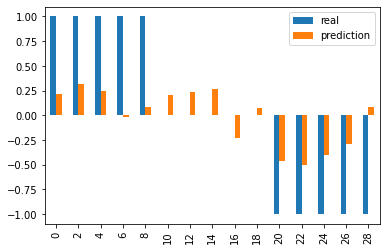

In [13]:
imdb_crop = 1000
imdb_predictions = get_predictions(imdb[:imdb_crop])
ax = imdb_predictions.plot(kind="bar")

As we had hoped, this model now performs well on simple adjectives. But we lost our edge on financial headlines, so we need to somehow combine both models.

In [17]:
def get_scores(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset.headline, dataset.target, test_size=0.20, random_state=1)

    pipeline.fit(X_train, y_train)
    print(f"train score: {pipeline.score(X_train, y_train):.3f}")
    print(f"test score: {pipeline.score(X_test, y_test):.3f}")

## Train on both datasets

Let's try fitting our model on a blend of both datasets.

In [14]:
combined = pd.concat([imdb[:imdb_crop], fns])
combined = combined.sample(frac=1).reset_index(drop=True)
combined

,headline,sentiment,target
0,The parties have agreed to negotiate definitiv...,positive,1
1,"Pretax profit totaled EUR 9.0 mn , down from E...",negative,-1
2,F-Secure reported that : - The first half of 2...,neutral,0
3,The cooperation will involve Arena Partners bu...,neutral,0
4,Our in-depth expertise extends to the fields o...,neutral,0
...,...,...,...
5841,`` This is a win for all OEMs targeting to dev...,positive,1
5842,President and CEO Mika Vehvil+�inen says the p...,positive,1
5843,"I remember this film,it was the first film i h...",positive,1
5844,HELSINKI (Thomson Financial)- Kemira GrowHow s...,positive,1


train score: 0.995
test score: 0.304


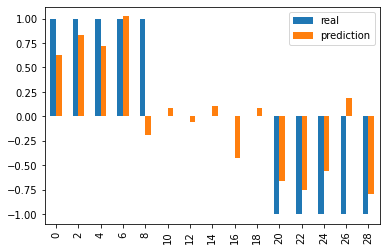

In [15]:
combined_predictions = get_predictions(combined)
ax = combined_predictions.plot(kind="bar")

Better on some headlines, but we still don't have the same edge as the first model.

## Take the average of the predictions

Instead let's try keeping both models separate, but take the **average of their predictions**.

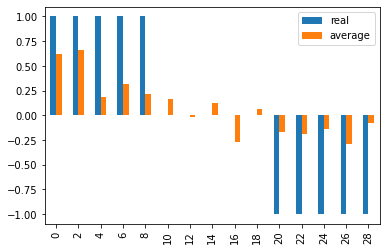

In [16]:
average_df = fns_predictions.copy()
average_df["average"] = pd.concat([fns_predictions.prediction, imdb_predictions.prediction], axis=1).mean(axis=1)
ax = average_df.drop("prediction", axis=1).plot(kind="bar")

Now we're doing well across the board. The predictions are still too muted on the negative side, so that's an area for further improvement.